# **Variational Auto-Encoders (VAEs) and the Evidence Lower-BOund (ELBO)**

### This practical



*   provides skeleton code for a VAE – you are tasked with filling in the missing bits and pieces
*   has a couple of experiments to visualize interesting/useful aspects of the VAE 
*   is implemented using the python library [JAX](https://jax.readthedocs.io/en/latest/index.html)
*   will give a conceptual, rather than technical, introduction to the ELBO and variants thereof





### Before getting started, let us recap the VAE. 

#### Background

VAE was simultaneously proposed by [Diederik P. Kingma and Max Welling](https://arxiv.org/abs/1312.6114) [1] and [Danilo Jimenez Rezende, Shakir Mohamed and Daan Wierstra](https://arxiv.org/abs/1401.4082) [2] independently. The former was published slightly prior to the latter, and has recieved considerably more citations. If you have not yet read/looked at either, I recommend checking out [1], as it will help you in this practical (and, of course, since it is a great piece of work). 

Essentially, a VAE can be seen as a mapping from an input space to a latent (hidden or unobserved) space, then from the latent space to an output space. It consists of two parts, called encoder and decoder. With the help of encoder, we can map a given input sample $x_{ori} \sim p(x)$ to a distribution over the latent space. The distribution is denoted by $q_{\phi}(z|x_{ori})$ and $\phi$ denotes the parameters of the encoder (optimized via training), called ([variational](https://www.cs.jhu.edu/~jason/tutorials/variational.html)) parameters. 

In mathematics, finding the best function (the distribution over the latent space in our case, i.e. $q_{\phi}(z|x_{ori})$) is done under the name of calculus of variations and this name also comes from that mathematical background. Variational approximation, (finding the best or closest function to a given function, in our case the true distribution over the latent sapce $p(z|x_{ori})$) is usually done because of the complexity of the original function (it means, it is hard to work with $p(z|x_{ori})$ because it has interactable terms).

So the idea of variational approximation is that to fix a family of distributions, say $Q$ (think of it as the set of all possible normal distributions $Q=\{\mathcal{N}(\mu,\sigma)| \mu \in \mathbb{R}, \sigma \in \mathbb{R}^+\}$), and then approximate a complex function, needless to say $p(z|x_{ori})$, with a simpler function $q_\phi(z|x_{ori}) \in Q$. To this end, we need to find the closest $q_\phi(z|x_{ori})$ to $p(z|x_{ori})$, and the parameters of $q_\phi(z|x_{ori})$ (in our example, a good $\mu$ and $\sigma$) are called **variational parameters**. The subscript $\phi$, also called variational paramters or encoder paramters, denotes that the distribution we get, depends on some other variables that has to be optimized (i.e. the variables that we use to map a given input $x$ to a distribution over the latent space, for example $\phi=\{W_1,W_2,b_1,b_2\}$ if we are using a two layer MLP).

Note that $q_\phi(z|x)$ is a function of two variables both $x$ and $z$ and when you plug in some specific $x$, you still have a function of $z$.  Therefore, $q_\phi(z|x)$ gives us the paramters of a distribution (in our example it gives us some specific $\mu$ and $\sigma$ after plugging it $x$). Then, after getting the paramters of a distribution over the latent space $q_\phi(z|x_{ori})$, it is time to reconstruct the input sample $x_{ori}$ from its latent representation $q_\phi(z|x_{ori})$, but the problem is that we can not use a function as input into the decoder! So what we can do is to draw (several) samples from the latent distribution $q_\phi(z|x_{ori})$ and recover a distribution over the  input space. Another the problem is that it is that, sampling is not differentiable, making our model indifferentiable. To see why, try to diffrentiate a sample drawn from a Normal distribution, i.e. while $x \sim \mathcal{N}(\mu,\sigma)$ try to compute the following: 
$$
\frac{dx}{d\mu}
$$

To solve the problem regarding the sampling and indifferentiability, [1] have proposed a trick called **reparameterization trick**, of which you'll hear more in the rest of this practical. But for now, it suffices to assume that we know we can use a sample like $z_{ori} \sim q_\phi(z|x_{ori})$, to map it back to the input sapce again, using a decoder, or so called **the generative** model. In our example, it is as simple as $z_{ori} \sim \mathcal{N}(\mu_{ori},\sigma_{ori})$ where the $\mu_{ori}$ and $\sigma_{ori}$ is obtained simply by plugging in $x_{ori}$ into the encoder, i.e. $q_\phi(z|x_{ori})$.

As the decoder is acting on samples of a distribution, and becomes stochastic by virtue of sampling, it defines a distribution over the input space. Therefore, the **distribution recovered** from $z_{ori}$ by the decoder, is denoted by $p_\theta(x|z_{ori})$.

The $\theta$ subscript is the parameters of the generative model, also called generative paramters are optimized jointly with $\phi$. Finally, we can *decode* $z_{ori}$ by sampling from $p_{\theta}(x|z_{ori})$. The decoding of $z_{ori}$, i.e. $x_{rec}\sim p_{\theta}(x|z_{ori})$, is commonly referred to as the *reconstruction*.

Note that in the original paper you do not see any distinction between $x_{ori}$, $x_{rec}$ and $x$ as they are in the same space, but it is added here to make it easy to explain the idea! Following [1], we avoid the use of subscripts in the rest of the practical. 

### Why?
There are plenty of interesting tasks that can be tackled using VAEs. Some important examples include dimensionality reduction (encoding $x$ as $z$, such that dim($z$) < dim($x$)), noise filtering (a.k.a. reconstructing the input), generating synthetic data (sampling from $p_{\theta}(x|z)$) and density estimation. Let us zoom in on the latter.

Say we are interested in learning the posterior distribution $p(z|x)$ for whatever reason. In most interesting scenarios, however, we cannot learn it since it is intractable. The intractability of

$$
  p(z|x) = \frac{p(z,x)}{p(x)}
$$

stems from not being able to compute $p(x) = \int p(z, x) dz$ as it involves marginalizing over all $z$. Instead of learning $p(z|x)$ directly, we have to approximate it.



### How?
The VAE is a form of (amortized) variational inference (VI). In VI we approximate the intractable posterior using a simpler distribution, $q_{\phi}(z|x)$, inferring $\phi$ by estimating the marginal log-likelihood, $\log p(x)$. Consequently, we actually estimate two densities.

The inference is performed by *maximizing* the **E**vidence **L**ower **BO**ound (ELBO in short), $\mathcal{L}$:

$$\mathbb{E}_{q_{\phi}(z|x)}\left[\log\frac{p(z, x)}{q_{\phi}(z|x)}\right] \triangleq \mathcal{L} = - D_{KL}(q_{\phi}(z|x)||p(z)) +\mathbb{E}_{q_{\phi}(z|x)}\left[\log p_\theta(x|z)\right]$$

where $D_{KL}(q_{\phi}(z|x)||p(z))$ is the Kullback-Leibler (KL) divergence. The KL divergence is strictly non-negative, and zero if and only if $q_{\phi}(z|x) = p(z)$, while the marginal log-likelihood, $\log p(x)$, is a constant. It is also possible to write:

$$\log p(x) = D_{KL}(q_{\phi}(z|x)||p(z|x)) + \mathcal{L}$$
The $D_{KL}(q_{\phi}(z|x)||p(z|x))$ term is called **the variational gap** and is non-negative, so it can be seen that we have:
$$\log p(x) \geq \mathcal{L}$$

Therefore, the ELBO is a lower bound on the marginal log-likelihood and maximizing $\mathcal{L}$ indirectly minimizes $D_{KL}(q_{\phi}(z|x)||p(z|x))$ (which we do not have), giving us a better approximation of the intractable posterior.  See [1] for the derivation.
Note that the negated ELBO is often referred to as the negative log-likelihood (NLL).

In this practical, as in [1], we will assume that $q_\phi(z|x) = \mathcal{N}(z;\mu,\sigma^2)$, $p(z)=\mathcal{N}(0,1)$ and $p_{\theta}(x|z) = \text{Bernoulli}(x;θ$). Hence we can evaluate all terms in the ELBO, where $p(z,x) = p_\theta(x|z)p(z)$. 

### Benchmarking VAEs in Density Estimation Tasks
This will be a recurring topic in this practical. Namely, you may train on whichever objective function you deem fitting, however when reporting your results in order to compare the performance of your algorithm, the evaluation of the **correct** objective is crucial. For instance, if you want to compare your VAE's NLL scores with others', then make sure the objective function is in fact a lower-bound on the marginal log-likelihood. More on that later.

## VAE in JAX
Now, let's import the necessary libraries. Feel free to add imports as you wish.

In [1]:
import os
import time
from tqdm import tqdm
import distrax as dx

import matplotlib.pyplot as plt
from tensorflow_probability.substrates import jax as tfp
import jax
import jax.numpy as jnp
from jax import jit, grad, lax, random
from jax.example_libraries import optimizers
from jax.example_libraries import stax
from jax.example_libraries.stax import Dense, FanOut, Relu, Softplus, Sigmoid
import numpy as np
from torch.utils import data
from torchvision.datasets import MNIST, FashionMNIST
from functools import partial

# IMPORTANT NOTE:
# if you have got a NaN loss and/or have trouble debugging. Then, set
# jax_disable_jit to True. This will help you print out the variables.
jax.config.update('jax_disable_jit', False)

For the sake of simplicity, we use the MNIST dataset in this practical.

The next cell creates a PyTorch dataloader. Using either PyTorch or TensorFlow dataloaders seems to (currently) be the practice when working with JAX. The code has been slighlty altered after being copying from [here](https://colab.research.google.com/github/google/jax/blob/master/docs/notebooks/Neural_Network_and_Data_Loading.ipynb#scrollTo=94PjXZ8y3dVF).

In [10]:
def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple,list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory, 
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=jnp.float32))

In [3]:
batch_size = 248
# Define our dataset, using torch datasets
mnist_dataset = MNIST('/tmp/mnist/', download=True, transform=FlattenAndCast())
training_generator = NumpyLoader(mnist_dataset, batch_size=batch_size, num_workers=0)
mnist_dataset_test = MNIST('/tmp/mnist/', download=True, train=False)
test_images = jnp.array(mnist_dataset_test.test_data.numpy().reshape(len(mnist_dataset_test.test_data), -1), dtype=jnp.float32)
test_labels = jnp.array(mnist_dataset_test.test_labels)

c:\Users\Naifh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\datasets\mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
c:\Users\Naifh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\datasets\mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


### Initializing the Network and Optimizer

Next we put together a simple VAE, using two-layered MLPs with 300 hidden units for both the encoder and decoder networks. Note that the two parallel ultimate layers in the encoder net output latent_dimensions-dimensional arrays. **Based on the respective ranges of these two outputs, which one is $\mu$ and which is $\sigma$?**

Also, note that we apply **the sigmoid function on the outputs of the decoder**. Recall that $p_\theta(x|z)$ models the paramters of a Bernoulli distribution.

Initialize the networks and the Adam optimizer.

In [13]:
latent_dimensions = 2

# encoder defs
encoder_init, encode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    FanOut(2),
    stax.parallel(Dense(latent_dimensions), stax.serial(Dense(latent_dimensions), Softplus)),
)

# decoder defs
decoder_init, decode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    Dense(28 * 28), Sigmoid
)


# initialize networks and get params
enc_init_key, dec_init_key = random.split(random.PRNGKey(100))
_, encoder_params = encoder_init(enc_init_key, input_shape=(-1, 28 * 28))
_, decoder_params = decoder_init(dec_init_key,
                                 input_shape=
                                 (-1, latent_dimensions))
params = encoder_params, decoder_params

# initialize optimizer
opt_init, opt_update, get_params = optimizers.adam(step_size=0.001)
opt_state = opt_init(params)

### Task 1: Reparameterization Trick
See [1] to figure out what **reparameterization trick** is, and implement the reparameterization trick in the following function.

In [18]:
def sample(rng, mu, std):
  # use the reparameterization trick
  eps = random.normal(rng, mu.shape)
  z = mu + eps * std
  return z

Continuing with the VAE pipeline. "@jit" is a JAX decoration which apparently heavily speeds up operations. Beware, however, that it does not support all operations, putting restrictions on the function it decorates.

In [11]:
@jit
def forward(params, x, rng):
    encoder_params, decoder_params = params
    phi = encode(encoder_params, inputs=x)
    z = sample(rng, mu=phi[0], std=phi[1])
    bernoulli_theta = decode(decoder_params, z)
    return phi, z, bernoulli_theta

### Task 2: ELBO
**Compute the ELBO in the following function.** Feel free to add or remove input arguments, except for params; params should be the first input argument (it's due to how JAX computes gradients). Also, since the optimizer *minimizes* the objective function, make sure to return the negated ELBO. Hint: recall the definition of the ELBO, note that it can be Monte Carlo approximated as follows

$\mathcal{L} = \mathbb{E}_{q_\phi(z|x)}\left[ \log\frac{p_\theta(x|z)p(z)}{q_\phi(z|x)} \right] \simeq \frac{1}{L}\sum_l \log\frac{p_\theta(x|z_l)p(z_l)}{q_\phi(z_l|x)}$,

and, following [1], let $L=1$. 

Finally, package `tfp.distributions` could be used to calculate the (log) probability of different distributions. For instance, we could use `tfp.distributions.Bernoulli` to compute the likelihood of the pixels.

In [15]:
@jit
def get_elbo(params, x, rng):
    # the negative elbo should be a scalar value, i.e. averaged over the mini-batch.
        (mu,sigma), z, bernoulli_theta = forward(params, x, rng)
        q_q_z = dx.Normal(loc=mu, scale=sigma)
        p_x_z = tfp.distributions.Bernoulli(probs = bernoulli_theta)
        p_z  = dx.Normal(loc =0., scale=1.)
        elbo_all = jnp.sum(p_x_z.log_prob(x), axis=1) + jnp.sum(p_z.log_prob(z), axis=1) - jnp.sum(q_q_z.log_prob(z), axis=1) 
        elbo = jnp.mean(elbo_all)
        return -elbo

Now to the training and evaluation steps. Note that we have normalized the pixel values in order for them to fit the probabilistic model.

In [16]:
def epoch_step(epoch, training_generator, opt_state):
    # an rng, random number generator, is required for all stochastic operations
    rng = random.PRNGKey(epoch)
    nlls = []
    for i, (x, y) in enumerate(tqdm(training_generator)):
        x = jax.device_put(x) / 255.0

        value, grads = jax.value_and_grad(get_elbo)(get_params(opt_state), x, rng)
        opt_state = opt_update(i, grads, opt_state)

        nlls.append(value)
    return opt_state, np.mean(nlls)

Luckily, the complete test set fits in the memory, and so we can compute the average NLL on all images at once without taking the batch size into account. This might not always be possible, in which case you must be careful regarding how you average the NLL scores, since all batches needn't be of the same size. Failing to do so will make your NLL scores unfit for benchmarking.

In [2]:
def evaluate(opt_state, x, test_rng):
    params = get_params(opt_state)
    x = jax.device_put(x) / 255.0
    nll = get_elbo(params, x, test_rng)
    return nll

**Plot the NLL vs. epochs curves (train and test) and see that they're decaying.**

In [20]:
n_epochs = 20
test_key = random.PRNGKey(10)
for epoch in range(n_epochs):
    print("Epoch: ", epoch)
    opt_state, nll_train = epoch_step(epoch, training_generator, opt_state)
    nll_test = evaluate(opt_state, test_images, test_key)
    print(f"Train NLL: {nll_train}")
    print("Test NLL: ", nll_test, '\n')

Epoch:  0


  0%|          | 0/242 [00:00<?, ?it/s]

100%|██████████| 242/242 [00:11<00:00, 20.70it/s]


Train NLL: 209.583251953125
Test NLL:  180.55592 

Epoch:  1


100%|██████████| 242/242 [00:07<00:00, 33.54it/s]


Train NLL: 177.026611328125
Test NLL:  176.14752 

Epoch:  2


100%|██████████| 242/242 [00:07<00:00, 33.00it/s]


Train NLL: 172.21221923828125
Test NLL:  171.41495 

Epoch:  3


100%|██████████| 242/242 [00:07<00:00, 31.91it/s]


Train NLL: 169.2873077392578
Test NLL:  169.55232 

Epoch:  4


100%|██████████| 242/242 [00:07<00:00, 30.92it/s]


Train NLL: 167.700439453125
Test NLL:  167.94327 

Epoch:  5


100%|██████████| 242/242 [00:07<00:00, 31.52it/s]


Train NLL: 166.34303283691406
Test NLL:  166.79247 

Epoch:  6


100%|██████████| 242/242 [00:07<00:00, 31.82it/s]


Train NLL: 165.0857391357422
Test NLL:  165.67206 

Epoch:  7


100%|██████████| 242/242 [00:07<00:00, 32.69it/s]


Train NLL: 163.91004943847656
Test NLL:  164.61989 

Epoch:  8


100%|██████████| 242/242 [00:07<00:00, 31.62it/s]


Train NLL: 162.7447052001953
Test NLL:  163.31747 

Epoch:  9


100%|██████████| 242/242 [00:07<00:00, 32.47it/s]


Train NLL: 161.54112243652344
Test NLL:  162.30359 

Epoch:  10


100%|██████████| 242/242 [00:07<00:00, 32.28it/s]


Train NLL: 160.26475524902344
Test NLL:  161.02834 

Epoch:  11


100%|██████████| 242/242 [00:07<00:00, 31.99it/s]


Train NLL: 159.01197814941406
Test NLL:  159.94334 

Epoch:  12


100%|██████████| 242/242 [00:07<00:00, 31.71it/s]


Train NLL: 157.9003448486328
Test NLL:  159.1362 

Epoch:  13


100%|██████████| 242/242 [00:07<00:00, 32.50it/s]


Train NLL: 156.9309539794922
Test NLL:  158.03905 

Epoch:  14


100%|██████████| 242/242 [00:07<00:00, 32.66it/s]


Train NLL: 156.1013641357422
Test NLL:  157.32225 

Epoch:  15


100%|██████████| 242/242 [00:07<00:00, 32.24it/s]


Train NLL: 155.30303955078125
Test NLL:  156.68814 

Epoch:  16


100%|██████████| 242/242 [00:07<00:00, 31.10it/s]


Train NLL: 154.6072540283203
Test NLL:  155.98682 

Epoch:  17


100%|██████████| 242/242 [00:07<00:00, 31.97it/s]


Train NLL: 153.95654296875
Test NLL:  155.65149 

Epoch:  18


100%|██████████| 242/242 [00:07<00:00, 31.86it/s]


Train NLL: 153.32302856445312
Test NLL:  154.99287 

Epoch:  19


100%|██████████| 242/242 [00:07<00:00, 32.25it/s]


Train NLL: 152.71578979492188
Test NLL:  154.44748 



### Task 3: Experiments

Let's put the trained VAE to use by visulizing the latent space and sampling synthetic data. Complete the following code snippets to do so.
**Visualize the latent space. Use the labels $y$ to color the latent representations in a scatter plot.** 

Hint: Encode the training or test set, and use `plt.scatter`. 

Plotting Latent Space


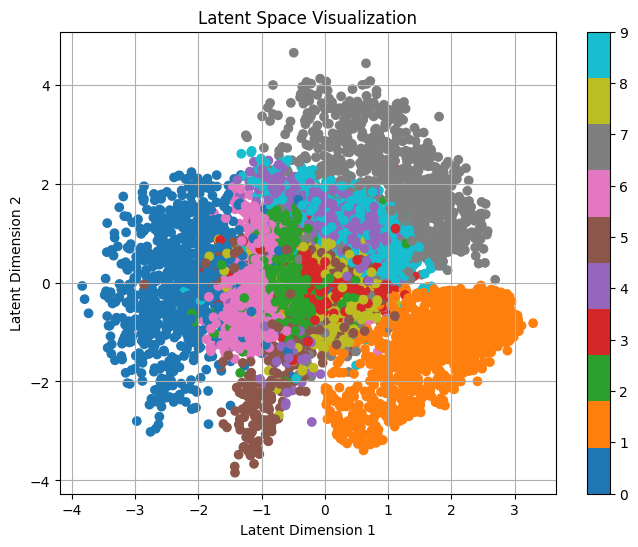

In [32]:
def show_latent_space():
  encoder_params = get_params(opt_state)[0]
  # Encoder params is supposed to give me parameters for the sampler distribution and i need the decoder params to get the sample image, we are using normal for z
  print("Plotting Latent Space")
  test_images
  phi = encode(encoder_params, inputs=test_images / 255.0)
  z = phi[0]
  plt.figure(figsize=(8, 6))
  plt.scatter(z[:, 0], z[:, 1], c=test_labels, cmap='tab10')
  plt.colorbar()
  plt.grid()
  plt.xlabel('Latent Dimension 1')
  plt.ylabel('Latent Dimension 2')
  plt.title('Latent Space Visualization')
  plt.show()
show_latent_space()

Monitor the reconstruction quality of your model. Visualize a single input image together its reconstruction.

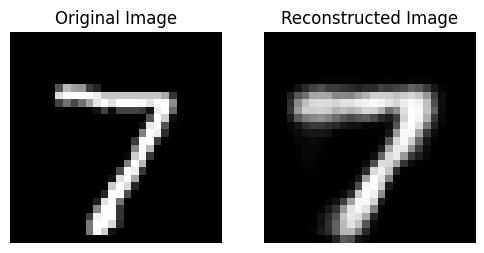

In [ ]:
def reconstruct_an_image(image_index=0):
  x = test_images[image_index]  # the image to be reconstructed
  params = get_params(opt_state)
  decoder_params = params[1]
  # call the forwad function and use its output to reconstruct the image
  test_key = random.PRNGKey(10)
  x = jax.device_put(x[None, :]) / 255.0
  (_, _), _, bernoulli_theta = forward(params, x, random.PRNGKey(0))
  x_reconstructed = bernoulli_theta


  plt.figure(figsize=(6, 3))
  plt.subplot(1, 2, 1)
  plt.title('Original Image')
  plt.imshow(x.reshape(28, 28), cmap='gray')
  plt.axis('off')
  plt.subplot(1, 2, 2)
  plt.title('Reconstructed Image')
  plt.imshow(x_reconstructed.reshape(28, 28), cmap='gray')
  plt.axis('off')
  plt.show()
for i in range(5):
  reconstruct_an_image(i)


**Generate synthetic data.** Hint: sample $z\sim p(z)$ or "walk" in the latent space. Decode the $z$ you sample/visit and plot the decoded image. Think about what output you expect when you sample from 1) a Bernoulli distribution, or 2) regard the Bernoulli parameter as the sample.

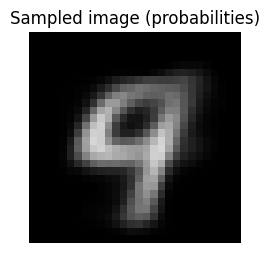

In [ ]:
#@jit
def sample_image(decoder_params = None, seed=2):
    # feel free to add other args to the function
    # either sample from the prior, or walk/do a grid search over z's
    # then use decoder_params to decode the latent samples
    # get decoder params if not passed
    decoder_params = get_params(opt_state)[1] if decoder_params is None else decoder_params

    # sample z ~ N(0, I) as a batch of size 1
    key = random.PRNGKey(seed)
    z = random.normal(key, (1, latent_dimensions))   

    decoded = decode(decoder_params, z)             
    probs = decoded                                   

    probs_host = jax.device_get(probs).squeeze()     
    if probs_host.size == 28*28:
        img = probs_host.reshape(28, 28)
    else:
        img = probs_host


    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.title('Sampled image (probabilities)')
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')

    
    #return sample_img
for i in range(5):
  sample_image(seed=i)


## $\beta$-VAE

The $\beta$-VAE was proposed by [Higgins et al.](https://openreview.net/pdf?id=Sy2fzU9gl) in 2017 and is a straightforward but important extension of the VAE. In terms of architecture, $\beta$-VAE and VAE are indistinguishable. In fact, the novelty in the work by Higgins et al. lies in a minor modification of the ELBO objective, the $\beta$-objective

$\mathcal{L}_\beta = \mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)] - \beta \mathbb{E}_{q_\phi(z|x)}[\log \frac{q_\phi(z|x)}{p(z)}]$,

where $\beta\geq0$ is a hyperparameter weighting the KL divergence 

KL$(q_\phi(z|x)\Vert p(z)) = \mathbb{E}_{q_\phi(z|x)}[\log \frac{q_\phi(z|x)}{p(z)}]$. Observe that we retrieve the standard ELBO when $\beta=1$.

This objective is useful for 

* emphasizing high-fidelity reconstructions *or* disentangling the latent space
* obtaining an increased interpretability
* doing KL warm-up.

The effects of the $\beta$-objective are mostly visible asymptotically, why we may not experience the full power of it here (e.g., [NVAE](https://arxiv.org/pdf/2007.03898.pdf) applies KL warm-up during the *first 25k iterations*). 

However, plenty of the state-of-the-art VAEs (in terms of density estimation) apply KL warm-up (e.g. NVAE, [VampPrior](https://arxiv.org/pdf/1705.07120.pdf), [LadderVAE](https://arxiv.org/pdf/1602.02282.pdf); see LadderVAE for a nice motivation of KL warm-up), so it is good to know. Also, aside from being very straightforward to implement, the $\beta$-objective leads us to the following important note.

**Important note**: as pointed out by [Hoffman et al.](http://bayesiandeeplearning.org/2017/papers/66.pdf), the $\beta$-objective shown above cannot be considered an evidence lower-bound. Hence, test scores based on the $\beta$-objective **should not be used for benchmarking against proper marginal log-likelihood estimates (such as the ELBO)**. If you are interested, try to reverse the derivations of the ELBO in [1] while including $\beta$.

### Task 4: $\beta$-ELBO

**Compute the $\beta$-objective in the following function.**

Hint: this should require minimal changes to the ```get_elbo```
function above. Also, observe that



$\mathcal{L}_\beta \simeq \frac{1}{L}\sum_l \log p_\theta(x|z_l)-\beta\log\frac{q_\phi(z_l|x)}{p(z_l)}$.


In [47]:
@jit
def get_beta_elbo(params, x, rng, beta):
    # the negative elbo should be a scalar value, i.e. averaged over the mini-batch.
        (mu,sigma), z, bernoulli_theta = forward(params, x, rng)
        q_q_z = dx.Normal(loc=mu, scale=sigma)
        p_x_z = tfp.distributions.Bernoulli(probs = bernoulli_theta)
        p_z  = dx.Normal(loc =0., scale=1.)
        elbo_all = jnp.sum(p_x_z.log_prob(x), axis=1) + beta*jnp.sum(p_z.log_prob(z), axis=1) - beta*jnp.sum(q_q_z.log_prob(z), axis=1) 
        elbo = jnp.mean(elbo_all)
        return -elbo

Now we define ```epoch_step_beta``` that calls ```get_beta_elbo``` instead of ```get_elbo```, and so that it can take a $\beta\geq 0$ as input.

In [48]:
def epoch_step_beta(epoch, training_generator, opt_state, beta):
    # an rng, random number generator, is required for all stochastic operations
    rng = random.PRNGKey(epoch)
    nlls = []
    for i, (x, y) in enumerate(tqdm(training_generator)):
        x = jax.device_put(x) / 255
        value, grads = jax.value_and_grad(get_beta_elbo)(get_params(opt_state),
                                                         x, 
                                                         rng,
                                                         beta)
        opt_state = opt_update(i, 
                               grads, 
                               opt_state)
        nlls.append(value)
    return opt_state, np.mean(nlls)

Again, importantly, we have used $\beta=1$ as default in ```evaluate_beta```, which makes the evaluation scores comparable to those of the standard VAE that we trained above.

In [49]:
def evaluate_beta(opt_state, x, test_rng,beta=1):
    params = get_params(opt_state)
    x = jax.device_put(x) / 255
    nll = get_beta_elbo(params,
                        x, 
                        test_rng,beta)
    return nll

Before retraining the VAE, or $\beta$-VAE, we need to reinitialize the encoder/decoder nets and the optimizer above. This is done by simply running the cell below.

In [63]:
beta = 1  # just an example for a big beta. Try with other values!
latent_dimensions = 2

# encoder defs
encoder_init, encode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    FanOut(2),
    stax.parallel(Dense(latent_dimensions), stax.serial(Dense(latent_dimensions), Softplus)),
)

# decoder defs
decoder_init, decode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    Dense(28 * 28), Sigmoid
)


# initialize networks and get params
enc_init_key, dec_init_key = random.split(random.PRNGKey(100))
_, encoder_params = encoder_init(enc_init_key, input_shape=(-1, 28 * 28))
_, decoder_params = decoder_init(dec_init_key,
                                 input_shape=
                                 (-1, latent_dimensions))
params = encoder_params, decoder_params

# initialize optimizer
opt_init, opt_update, get_params = optimizers.adam(step_size=0.001)
opt_state = opt_init(params)

Rerun the experiments section below. Any difference? If you train for a few couple of epochs, then we shouldn't expect huge variations. But perhaps setting $\beta$ to something very big will affect the distribution of $z$'s in the latent space? Does setting $\beta=0$ affect the fidelity of the reconstructed image? Why would we, at least asymptotically, expect these effects?

### Task 4: $\beta$-Experiments

In [64]:
n_epochs = 20
train_key,test_key = random.split(random.PRNGKey(10))
for epoch in range(n_epochs):
    print("Epoch: ", epoch)
    opt_state, nll_train = epoch_step_beta(epoch,
                                           training_generator, 
                                           opt_state,
                                           beta)
    nll_test = evaluate_beta(opt_state, 
                             test_images,
                             test_key)
    print("Train NLL: ", nll_train)
    print("Test NLL: ", nll_test)

Epoch:  0


100%|██████████| 242/242 [00:05<00:00, 41.14it/s]


Train NLL:  209.58325
Test NLL:  180.57715
Epoch:  1


100%|██████████| 242/242 [00:05<00:00, 41.53it/s]


Train NLL:  177.01929
Test NLL:  175.1761
Epoch:  2


100%|██████████| 242/242 [00:05<00:00, 40.83it/s]


Train NLL:  172.18788
Test NLL:  172.04645
Epoch:  3


100%|██████████| 242/242 [00:05<00:00, 40.75it/s]


Train NLL:  169.28609
Test NLL:  169.72157
Epoch:  4


100%|██████████| 242/242 [00:05<00:00, 40.82it/s]


Train NLL:  167.68832
Test NLL:  167.91116
Epoch:  5


100%|██████████| 242/242 [00:05<00:00, 40.48it/s]


Train NLL:  166.33125
Test NLL:  166.79141
Epoch:  6


100%|██████████| 242/242 [00:05<00:00, 41.42it/s]


Train NLL:  165.06508
Test NLL:  165.69891
Epoch:  7


100%|██████████| 242/242 [00:05<00:00, 40.82it/s]


Train NLL:  163.89568
Test NLL:  164.72939
Epoch:  8


100%|██████████| 242/242 [00:05<00:00, 40.55it/s]


Train NLL:  162.72212
Test NLL:  163.46107
Epoch:  9


100%|██████████| 242/242 [00:05<00:00, 40.57it/s]


Train NLL:  161.52124
Test NLL:  162.50838
Epoch:  10


100%|██████████| 242/242 [00:05<00:00, 40.70it/s]


Train NLL:  160.27069
Test NLL:  161.02592
Epoch:  11


100%|██████████| 242/242 [00:06<00:00, 40.10it/s]


Train NLL:  159.01488
Test NLL:  159.93007
Epoch:  12


100%|██████████| 242/242 [00:05<00:00, 41.72it/s]


Train NLL:  157.90819
Test NLL:  159.1237
Epoch:  13


100%|██████████| 242/242 [00:05<00:00, 40.73it/s]


Train NLL:  156.95793
Test NLL:  158.15074
Epoch:  14


100%|██████████| 242/242 [00:05<00:00, 40.47it/s]


Train NLL:  156.11931
Test NLL:  157.52509
Epoch:  15


100%|██████████| 242/242 [00:05<00:00, 40.62it/s]


Train NLL:  155.31825
Test NLL:  156.87733
Epoch:  16


100%|██████████| 242/242 [00:05<00:00, 40.38it/s]


Train NLL:  154.59682
Test NLL:  156.15968
Epoch:  17


100%|██████████| 242/242 [00:05<00:00, 42.00it/s]


Train NLL:  153.96019
Test NLL:  155.61954
Epoch:  18


100%|██████████| 242/242 [00:05<00:00, 40.70it/s]


Train NLL:  153.33655
Test NLL:  154.85686
Epoch:  19


100%|██████████| 242/242 [00:05<00:00, 40.79it/s]


Train NLL:  152.71446
Test NLL:  154.519


What has changed in the latent space? Try playing with a few values of $\beta$ and explain what affects the change in the latent space?

Plotting Latent Space


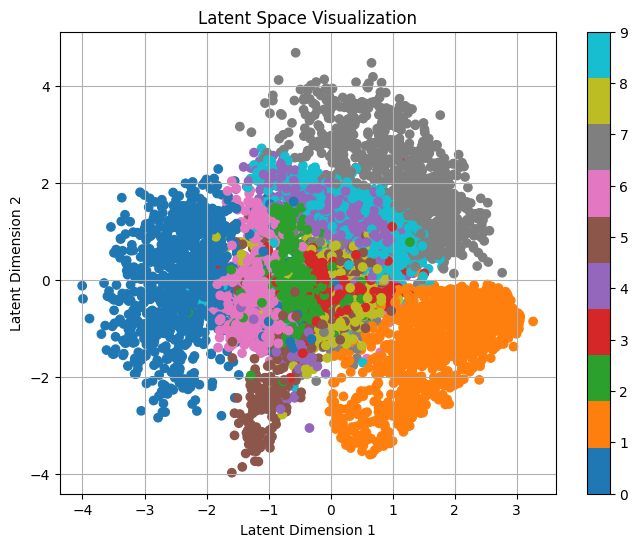

In [66]:
# visualize the latent space
def show_latent_space():
  encoder_params = get_params(opt_state)[0]
  # Encoder params is supposed to give me parameters for the sampler distribution and i need the decoder params to get the sample image, we are using normal for z
  print("Plotting Latent Space")
  test_images
  phi = encode(encoder_params, inputs=test_images / 255.0)
  z = phi[0]
  plt.figure(figsize=(8, 6))
  plt.scatter(z[:, 0], z[:, 1], c=test_labels, cmap='tab10')
  plt.colorbar()
  plt.grid()
  plt.xlabel('Latent Dimension 1')
  plt.ylabel('Latent Dimension 2')
  plt.title('Latent Space Visualization')
  plt.show()
show_latent_space()

What about the reconstruction quality of your model? Has it improved or degraded?

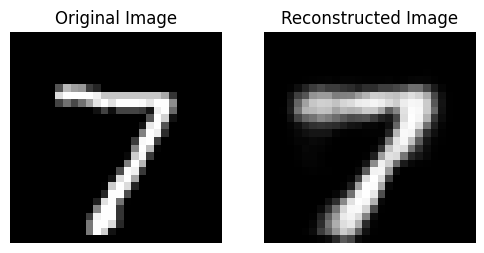

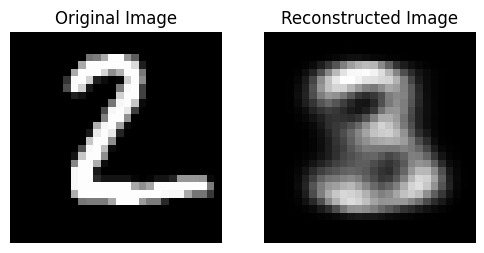

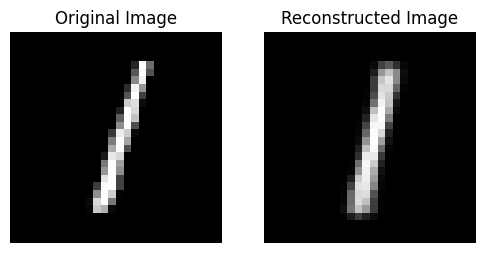

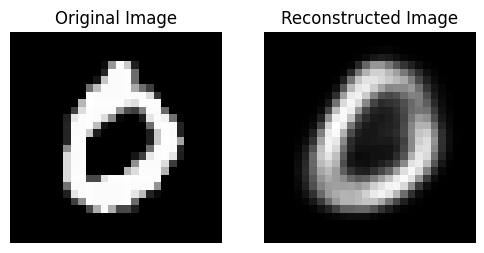

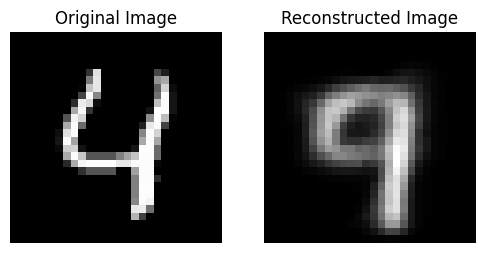

In [65]:
# reconstruct an image
def reconstruct_an_image_beta(image_index=0):
  x = test_images[image_index]  # the image to be reconstructed
  params = get_params(opt_state)
  decoder_params = params[1]
  # call the forwad function and use its output to reconstruct the image
  test_key = random.PRNGKey(10)
  x = jax.device_put(x[None, :]) / 255.0
  (_, _), _, bernoulli_theta = forward(params, x, random.PRNGKey(0))
  x_reconstructed = bernoulli_theta


  plt.figure(figsize=(6, 3))
  plt.subplot(1, 2, 1)
  plt.title('Original Image')
  plt.imshow(x.reshape(28, 28), cmap='gray')
  plt.axis('off')
  plt.subplot(1, 2, 2)
  plt.title('Reconstructed Image')
  plt.imshow(x_reconstructed.reshape(28, 28), cmap='gray')
  plt.axis('off')
  plt.show()

for i in range(5):
  reconstruct_an_image_beta(i)

Sample from the latent space and decode. Do you see any difference?

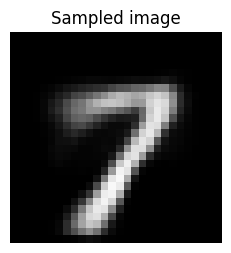

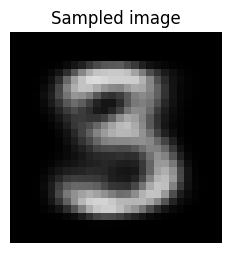

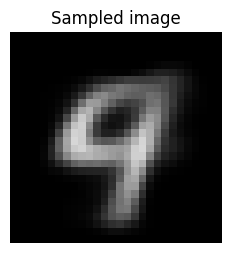

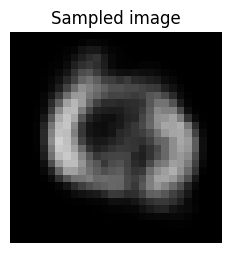

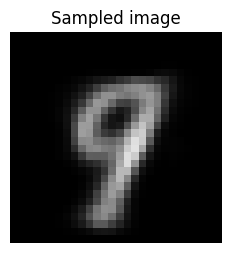

In [67]:
# sample a few images
#@jit
def sample_image_beta(decoder_params = None, seed=2):
    # feel free to add other args to the function
    # either sample from the prior, or walk/do a grid search over z's
    # then use decoder_params to decode the latent samples
    # get decoder params if not passed
    decoder_params = get_params(opt_state)[1] if decoder_params is None else decoder_params

    # sample z ~ N(0, I) as a batch of size 1
    key = random.PRNGKey(seed)
    z = random.normal(key, (1, latent_dimensions))   

    decoded = decode(decoder_params, z)             
    probs = decoded                                   

    probs_host = jax.device_get(probs).squeeze()     
    if probs_host.size == 28*28:
        img = probs_host.reshape(28, 28)
    else:
        img = probs_host


    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.title('Sampled image')
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')

    
    #return sample_img
for i in range(5):
  sample_image_beta(seed=i)


## Importance Weigthed Auto-Encoder (IWAE)


Similarily as for $\beta$-VAE, the distinguishing factor between the VAE and [IWAE](https://arxiv.org/abs/1509.00519) is the alternative objective function, the importance weighted ELBO (IWELBO):

$\mathcal{L}_{K} = \mathbb{E}_{q_\phi(z|x)}\left[\log\frac{1}{K}\sum_k\frac{p_\theta(x|z_k)p(z_k)}{q_\phi(z_k|x)}\right]$.

When computing $\mathcal{L}_{K}$ in contrast to the ELBO, we sample $K$ latent representations instead of one. Although this might seem like a simple extension, the IWELBO has huge implications on the field of VAEs, *as well as* the VI literature in general (see e.g. [Domke and Sheldon](https://arxiv.org/pdf/1808.09034.pdf)). Specifically (n.b., *not an exhaustive list*),

* it is a proper lower-bound on the marginal log-likelihood.
* it is an effective way of improving the NLL test scores (used by state-of-the-art VAEs when reporting NLL scores, including those mentioned above).

The former bullet implies that we *can* use IWELBO to benchmark our VAE against other VAEs, in contrast to the $\beta$-objective. The latter bullet implies that we probably *should* use it when benchmarking. Because, accoring to  Theorem 1 in the IWAE paper, the marginal log-likelihood estimates are montonically increasing with $K$, meaning that

$\mathcal{L}_{K}\geq \mathcal{L}_{K-1}\geq \mathcal{L}$.

### Task 5: IWELBO

Modify the following functions such that $K$ samples are drawn instead of 1. Then compute the IWELBO.

In [68]:
def sample_K(rng, mu, std, K):
  # use the reparameterization trick and sample K latent variables rather than 1
  sample_shape = (K,) + mu.shape
  eps = random.normal(rng, sample_shape)

  z = mu + eps * std
  return z

In [69]:
@partial(jax.jit, static_argnames=['K'])
def forward_K(params, x, rng, K):
    encoder_params, decoder_params = params
    phi = encode(encoder_params, inputs=x)
    z = sample_K(rng,
            mu=phi[0], 
            std=phi[1],
            K=K)
    bernoulli_theta = decode(decoder_params, z)
    return phi, z, bernoulli_theta

In [71]:
def get_iw_elbo(params, x, rng, K):
    # the negative elbo should be a scalar value, i.e. averaged over the mini-batch.
    (mu, sigma), z, bernoulli_theta = forward_K(params, x, rng, K)
    # hint: use the logsumexp() operation over K (available in the jax library) 
    # and subtract with logK to do the average inside the log.
    q_z_x = dx.Normal(loc=mu, scale=sigma)
    p_x_z = tfp.distributions.Bernoulli(probs = bernoulli_theta)
    p_z  = dx.Normal(loc =0., scale=1.)
    elbo_log_all = []
    for k in range (K):
        p_x_z_k = tfp.distributions.Bernoulli(probs = bernoulli_theta[k])
        z_k = z[k]
        log_p_x_z_k = jnp.sum(p_x_z_k.log_prob(x), axis=-1)  # (batch_size,)
        log_p_z_k = jnp.sum(p_z.log_prob(z_k), axis=-1)      # (batch_size,)
        log_q_z_x_k = jnp.sum(q_z_x.log_prob(z_k), axis=-1)  # (batch_size,)
        elbo_k = log_p_x_z_k + log_p_z_k - log_q_z_x_k      # (batch_size,)
        elbo_log_all.append(elbo_k)
    elbo_log_all = jnp.stack(elbo_log_all, axis=0)  
    iw_elbo_per_batch = jax.scipy.special.logsumexp(elbo_log_all, axis=0) - jnp.log(K)    
    iw_elbo = jnp.mean(iw_elbo_per_batch)
    return -iw_elbo

In [72]:
def epoch_step_K(epoch, training_generator, opt_state,beta):
    # an rng, random number generator, is required for all stochastic operations
    rng = random.PRNGKey(epoch)
    nlls = []
    for i, (x, y) in enumerate(tqdm(training_generator)):
        x = jax.device_put(x) / 255
        value, grads = jax.value_and_grad(get_iw_elbo)(get_params(opt_state),
                                                         x, 
                                                         rng,
                                                         K)
        opt_state = opt_update(i, 
                               grads, 
                               opt_state)
        nlls.append(value)
    return opt_state, np.mean(nlls)

In [73]:
def evaluate_K(opt_state, x, test_rng, K):
    params = get_params(opt_state)
    x = jax.device_put(x) / 255.0
    params, x = jax.lax.stop_gradient(params), jax.lax.stop_gradient(x)
    nll = get_iw_elbo(params, x, test_rng, K)
    return nll

Again, we need to re-initialize the network and optimizer states.

In [74]:
K = 4  # try with different values ranging from 1 to 10
latent_dimensions = 2

# encoder defs
encoder_init, encode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    FanOut(2),
    stax.parallel(Dense(latent_dimensions), stax.serial(Dense(latent_dimensions), Softplus)),
)

# decoder defs
decoder_init, decode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    Dense(28 * 28), Sigmoid
)


# initialize networks and get params
enc_init_key, dec_init_key = random.split(random.PRNGKey(100))
_, encoder_params = encoder_init(enc_init_key, input_shape=(-1, 28 * 28))
_, decoder_params = decoder_init(dec_init_key,
                                 input_shape=
                                 (-1, latent_dimensions))
params = encoder_params, decoder_params

# initialize optimizer
opt_init, opt_update, get_params = optimizers.adam(step_size=0.0001)  # this time we use a smaller learning rate due to numerical stability
opt_state = opt_init(params)

In [75]:
n_epochs = 20
test_key = random.PRNGKey(10)
for epoch in range(n_epochs):
    print("Epoch: ", epoch)
    opt_state, nll_train = epoch_step_K(epoch, 
                                      training_generator, 
                                      opt_state,
                                      K)
    nll_test = evaluate_K(opt_state, test_images, test_key, K)
    print("Train NLL: ", nll_train)
    print("Test NLL: ", nll_test)

Epoch:  0


100%|██████████| 242/242 [00:24<00:00,  9.97it/s]


Train NLL:  299.2372
Test NLL:  211.0073
Epoch:  1


100%|██████████| 242/242 [00:20<00:00, 11.97it/s]


Train NLL:  205.78946
Test NLL:  199.00496
Epoch:  2


100%|██████████| 242/242 [00:20<00:00, 11.69it/s]


Train NLL:  196.78645
Test NLL:  193.67401
Epoch:  3


100%|██████████| 242/242 [00:21<00:00, 11.20it/s]


Train NLL:  192.72404
Test NLL:  190.41257
Epoch:  4


100%|██████████| 242/242 [00:21<00:00, 11.16it/s]


Train NLL:  189.8279
Test NLL:  187.95993
Epoch:  5


100%|██████████| 242/242 [00:21<00:00, 11.08it/s]


Train NLL:  187.80635
Test NLL:  186.30913
Epoch:  6


100%|██████████| 242/242 [00:22<00:00, 10.93it/s]


Train NLL:  186.38869
Test NLL:  185.07137
Epoch:  7


100%|██████████| 242/242 [00:22<00:00, 10.80it/s]


Train NLL:  185.36086
Test NLL:  184.06479
Epoch:  8


100%|██████████| 242/242 [00:22<00:00, 10.71it/s]


Train NLL:  184.41096
Test NLL:  183.18172
Epoch:  9


100%|██████████| 242/242 [00:22<00:00, 10.78it/s]


Train NLL:  183.62888
Test NLL:  182.28874
Epoch:  10


100%|██████████| 242/242 [00:22<00:00, 10.69it/s]


Train NLL:  182.75185
Test NLL:  181.27965
Epoch:  11


100%|██████████| 242/242 [00:23<00:00, 10.51it/s]


Train NLL:  181.72234
Test NLL:  180.02847
Epoch:  12


100%|██████████| 242/242 [00:23<00:00, 10.49it/s]


Train NLL:  180.48544
Test NLL:  178.69966
Epoch:  13


100%|██████████| 242/242 [00:25<00:00,  9.61it/s]


Train NLL:  179.28137
Test NLL:  177.56406
Epoch:  14


100%|██████████| 242/242 [00:25<00:00,  9.67it/s]


Train NLL:  178.26443
Test NLL:  176.65224
Epoch:  15


100%|██████████| 242/242 [00:25<00:00,  9.65it/s]


Train NLL:  177.41193
Test NLL:  175.90509
Epoch:  16


100%|██████████| 242/242 [00:22<00:00, 10.56it/s]


Train NLL:  176.6945
Test NLL:  175.28732
Epoch:  17


100%|██████████| 242/242 [00:25<00:00,  9.43it/s]


Train NLL:  176.05421
Test NLL:  174.69815
Epoch:  18


100%|██████████| 242/242 [00:25<00:00,  9.63it/s]


Train NLL:  175.4518
Test NLL:  174.18292
Epoch:  19


100%|██████████| 242/242 [00:23<00:00, 10.14it/s]


Train NLL:  174.88535
Test NLL:  173.67645


Plot your NLL test scores as a function of $K$ for $K \in \{1,\dots,10\}$, and see if there is any improvement in NLL as K increases.

Epoch:  0


  0%|          | 0/242 [00:00<?, ?it/s]

100%|██████████| 242/242 [00:22<00:00, 10.87it/s]


Train NLL:  299.2372
Test NLL:  216.91753
Epoch:  1


100%|██████████| 242/242 [00:22<00:00, 10.71it/s]


Train NLL:  205.78946
Test NLL:  201.83525
Epoch:  2


100%|██████████| 242/242 [00:22<00:00, 10.94it/s]


Train NLL:  196.7835
Test NLL:  195.2581
Epoch:  3


100%|██████████| 242/242 [00:22<00:00, 10.74it/s]


Train NLL:  192.7213
Test NLL:  191.75671
Epoch:  4


100%|██████████| 242/242 [00:22<00:00, 10.87it/s]


Train NLL:  189.8246
Test NLL:  189.34953
Epoch:  5


100%|██████████| 242/242 [00:22<00:00, 10.80it/s]


Train NLL:  187.80182
Test NLL:  187.44257
Epoch:  6


100%|██████████| 242/242 [00:21<00:00, 11.08it/s]


Train NLL:  186.38371
Test NLL:  186.42758
Epoch:  7


100%|██████████| 242/242 [00:22<00:00, 10.80it/s]


Train NLL:  185.35619
Test NLL:  185.13411
Epoch:  8


100%|██████████| 242/242 [00:22<00:00, 10.74it/s]


Train NLL:  184.4061
Test NLL:  184.3736
Epoch:  9


100%|██████████| 242/242 [00:22<00:00, 10.73it/s]


Train NLL:  183.62361
Test NLL:  183.3043
Epoch:  0


100%|██████████| 242/242 [00:22<00:00, 10.93it/s]


Train NLL:  299.2372
Test NLL:  212.5596
Epoch:  1


100%|██████████| 242/242 [00:22<00:00, 10.95it/s]


Train NLL:  205.81049
Test NLL:  199.7448
Epoch:  2


100%|██████████| 242/242 [00:22<00:00, 10.53it/s]


Train NLL:  196.7807
Test NLL:  194.11235
Epoch:  3


100%|██████████| 242/242 [00:24<00:00,  9.88it/s]


Train NLL:  192.72523
Test NLL:  190.78679
Epoch:  4


100%|██████████| 242/242 [00:24<00:00,  9.71it/s]


Train NLL:  189.83054
Test NLL:  188.3524
Epoch:  5


100%|██████████| 242/242 [00:23<00:00, 10.18it/s]


Train NLL:  187.80717
Test NLL:  186.64789
Epoch:  6


100%|██████████| 242/242 [00:24<00:00,  9.72it/s]


Train NLL:  186.38739
Test NLL:  185.45528
Epoch:  7


100%|██████████| 242/242 [00:24<00:00,  9.88it/s]


Train NLL:  185.3585
Test NLL:  184.39613
Epoch:  8


100%|██████████| 242/242 [00:25<00:00,  9.49it/s]


Train NLL:  184.40883
Test NLL:  183.54568
Epoch:  9


100%|██████████| 242/242 [00:24<00:00,  9.70it/s]


Train NLL:  183.62639
Test NLL:  182.60583
Epoch:  0


100%|██████████| 242/242 [00:21<00:00, 11.25it/s]


Train NLL:  299.2372
Test NLL:  211.0073
Epoch:  1


100%|██████████| 242/242 [00:22<00:00, 10.93it/s]


Train NLL:  205.78946
Test NLL:  199.00496
Epoch:  2


100%|██████████| 242/242 [00:22<00:00, 10.99it/s]


Train NLL:  196.78351
Test NLL:  193.66115
Epoch:  3


100%|██████████| 242/242 [00:22<00:00, 10.99it/s]


Train NLL:  192.72661
Test NLL:  190.40845
Epoch:  4


100%|██████████| 242/242 [00:22<00:00, 10.86it/s]


Train NLL:  189.8241
Test NLL:  187.95654
Epoch:  5


100%|██████████| 242/242 [00:21<00:00, 11.31it/s]


Train NLL:  187.8029
Test NLL:  186.30623
Epoch:  6


100%|██████████| 242/242 [00:22<00:00, 10.93it/s]


Train NLL:  186.3862
Test NLL:  185.06923
Epoch:  7


100%|██████████| 242/242 [00:22<00:00, 10.92it/s]


Train NLL:  185.35857
Test NLL:  184.06271
Epoch:  8


100%|██████████| 242/242 [00:22<00:00, 10.76it/s]


Train NLL:  184.40877
Test NLL:  183.1798
Epoch:  9


100%|██████████| 242/242 [00:22<00:00, 10.73it/s]


Train NLL:  183.62656
Test NLL:  182.28734
Epoch:  0


100%|██████████| 242/242 [00:22<00:00, 10.84it/s]


Train NLL:  299.2372
Test NLL:  210.64162
Epoch:  1


100%|██████████| 242/242 [00:21<00:00, 11.34it/s]


Train NLL:  205.78946
Test NLL:  198.83153
Epoch:  2


100%|██████████| 242/242 [00:21<00:00, 11.11it/s]


Train NLL:  196.784
Test NLL:  193.53374
Epoch:  3


100%|██████████| 242/242 [00:21<00:00, 11.07it/s]


Train NLL:  192.72144
Test NLL:  190.30214
Epoch:  4


100%|██████████| 242/242 [00:22<00:00, 10.92it/s]


Train NLL:  189.82483
Test NLL:  187.84549
Epoch:  5


100%|██████████| 242/242 [00:21<00:00, 11.13it/s]


Train NLL:  187.8032
Test NLL:  186.20665
Epoch:  6


100%|██████████| 242/242 [00:22<00:00, 10.89it/s]


Train NLL:  186.38617
Test NLL:  184.95853
Epoch:  7


100%|██████████| 242/242 [00:22<00:00, 10.82it/s]


Train NLL:  185.35863
Test NLL:  183.96109
Epoch:  8


100%|██████████| 242/242 [00:22<00:00, 10.87it/s]


Train NLL:  184.40897
Test NLL:  183.07584
Epoch:  9


100%|██████████| 242/242 [00:22<00:00, 10.82it/s]


Train NLL:  183.627
Test NLL:  182.19525
Epoch:  0


100%|██████████| 242/242 [00:21<00:00, 11.47it/s]


Train NLL:  299.2372
Test NLL:  210.46864
Epoch:  1


100%|██████████| 242/242 [00:22<00:00, 10.88it/s]


Train NLL:  205.78946
Test NLL:  198.74632
Epoch:  2


100%|██████████| 242/242 [00:22<00:00, 10.87it/s]


Train NLL:  196.7835
Test NLL:  193.47581
Epoch:  3


100%|██████████| 242/242 [00:22<00:00, 10.78it/s]


Train NLL:  192.7264
Test NLL:  190.25066
Epoch:  4


100%|██████████| 242/242 [00:22<00:00, 10.57it/s]


Train NLL:  189.8235
Test NLL:  187.79059
Epoch:  5


100%|██████████| 242/242 [00:24<00:00, 10.01it/s]


Train NLL:  187.80269
Test NLL:  186.15529
Epoch:  6


100%|██████████| 242/242 [00:23<00:00, 10.16it/s]


Train NLL:  186.386
Test NLL:  184.9052
Epoch:  7


100%|██████████| 242/242 [00:22<00:00, 10.65it/s]


Train NLL:  185.35892
Test NLL:  183.91202
Epoch:  8


100%|██████████| 242/242 [00:21<00:00, 11.01it/s]


Train NLL:  184.40915
Test NLL:  183.02614
Epoch:  9


100%|██████████| 242/242 [00:22<00:00, 10.78it/s]


Train NLL:  183.62732
Test NLL:  182.15175
Epoch:  0


100%|██████████| 242/242 [00:21<00:00, 11.43it/s]


Train NLL:  299.2372
Test NLL:  210.37057
Epoch:  1


100%|██████████| 242/242 [00:21<00:00, 11.30it/s]


Train NLL:  205.79819
Test NLL:  198.69682
Epoch:  2


100%|██████████| 242/242 [00:21<00:00, 11.43it/s]


Train NLL:  196.79245
Test NLL:  193.45082
Epoch:  3


100%|██████████| 242/242 [00:21<00:00, 11.06it/s]


Train NLL:  192.73709
Test NLL:  190.24374
Epoch:  4


100%|██████████| 242/242 [00:21<00:00, 11.01it/s]


Train NLL:  189.8439
Test NLL:  187.7782
Epoch:  5


100%|██████████| 242/242 [00:22<00:00, 10.87it/s]


Train NLL:  187.81473
Test NLL:  186.13577
Epoch:  6


100%|██████████| 242/242 [00:21<00:00, 11.15it/s]


Train NLL:  186.39305
Test NLL:  184.8815
Epoch:  7


100%|██████████| 242/242 [00:22<00:00, 11.00it/s]


Train NLL:  185.36325
Test NLL:  183.8838
Epoch:  8


100%|██████████| 242/242 [00:22<00:00, 11.00it/s]


Train NLL:  184.41174
Test NLL:  182.9966
Epoch:  9


100%|██████████| 242/242 [00:22<00:00, 10.89it/s]


Train NLL:  183.62971
Test NLL:  182.12614


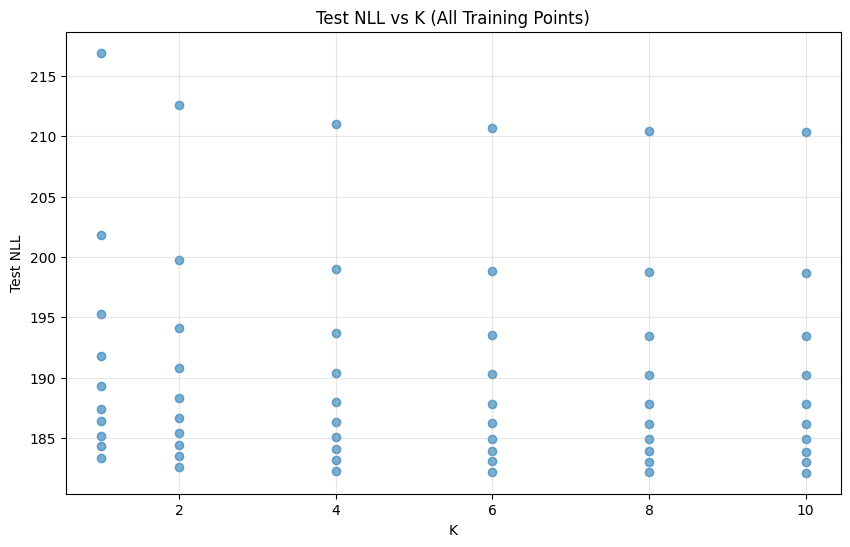

: 

In [ ]:
def plot_test_nll_vs_k():
  # initialize optimizer
  

  all_nll_tests = []
  all_k_values = []
  for K in [1,2,4,6,8,10]:
    # make sure it is re-initialized for each K
    latent_dimensions = 2

    # encoder defs
    encoder_init, encode = stax.serial(
        Dense(300), Relu,
        Dense(300), Relu,
        FanOut(2),
        stax.parallel(Dense(latent_dimensions), stax.serial(Dense(latent_dimensions), Softplus)),
    )

    # decoder defs
    decoder_init, decode = stax.serial(
        Dense(300), Relu,
        Dense(300), Relu,
        Dense(28 * 28), Sigmoid
    )


    # initialize networks and get params
    enc_init_key, dec_init_key = random.split(random.PRNGKey(100))
    _, encoder_params = encoder_init(enc_init_key, input_shape=(-1, 28 * 28))
    _, decoder_params = decoder_init(dec_init_key,
                                    input_shape=
                                    (-1, latent_dimensions))
    params = encoder_params, decoder_params

    # initialize optimizer
    opt_init, opt_update, get_params = optimizers.adam(step_size=0.0001)  # this time we use a smaller learning rate due to numerical stability
    opt_state = opt_init(params)



    # trail for each k value
    n_epochs = 10
    test_key = random.PRNGKey(10)
    for epoch in range(n_epochs):
        print("Epoch: ", epoch)
        opt_state, nll_train = epoch_step_K(epoch, 
                                          training_generator, 
                                          opt_state,
                                          K)
        nll_test = evaluate_K(opt_state, test_images, test_key, K)
        print("Train NLL: ", nll_train)
        print("Test NLL: ", nll_test)
        all_nll_tests.append(nll_test)
        all_k_values.append(K)
  plt.figure(figsize=(10, 6))
  plt.scatter(all_k_values, all_nll_tests, alpha=0.6)
  plt.xlabel('K')
  plt.ylabel('Test NLL')
  plt.title('Test NLL vs K (All Training Points)')
  plt.grid(True, alpha=0.3)
  plt.show()
plot_test_nll_vs_k()

Finally, it is valuable to know, how long did it take you to finish this practical?